## 1 - 单个 TLU（Threshold Logic Unit）

In [44]:
import numpy as np

In [45]:
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

In [46]:
iris = load_iris() # data, target
X = iris.data[:, (2, 3)] # petal length, petal width
y = (iris.target == 0).astype(np.int) # 仅取出 setosa 这一种，其他的舍掉。
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [47]:
per_clf = Perceptron()
per_clf.fit(X, y)
y_pred = per_clf.predict([[2, 0.5]])
y_pred

array([0])

1 等效于SGDclassifier: loss='perceptron', learning_rate='constant', eta0=1, penalty=None

2 硬极限激活，不输出概率。

### 预测绘图

In [48]:
a = -per_clf.coef_[0, 0] / per_clf.coef_[0, 1]
b = -per_clf.intercept_ / per_clf.coef_[0, 1]

In [49]:
axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
    np.linspace(axes[0], axes[1], 500).reshape(-1, 1), # 0-5划分为500份，然后修改维度为500*1
    np.linspace(axes[2], axes[3], 200).reshape(-1, 1), # 0-2划分为200份，然后修改维度为200*1
)

X_new = np.c_[x0.ravel(), x1.ravel()] # ravel相当于flatten，但是返回的是数组的视图
y_predict = per_clf.predict(X_new) # 对铺开的部分进行预测
zz = y_predict.reshape(x0.shape) # 还原成原来的 200*500

In [55]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

[0, 5, 0, 2]

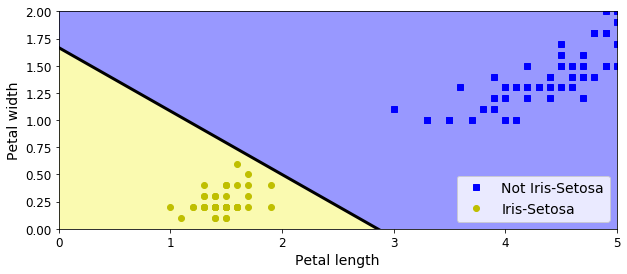

In [56]:
# 绘图
plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], 'bs', label='Not Iris-Setosa') # blue square
plt.plot(X[y==1, 0], X[y==1, 1], 'yo', label='Iris-Setosa') # yello circle
# X[y==0] 是提取了所有y==0的那些行，然后后一个0是提取第0列
plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], 'k-', linewidth=3) # 画分割线
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap) # 绘制填充区域
plt.xlabel('Petal length', fontsize=14)
plt.ylabel('Petal width', fontsize=14)
plt.legend(loc='lower right', fontsize=14)
plt.axis(axes)


## 2 - 激活函数

In [58]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return ((f(z + eps) - f(z - eps)) / (2 * eps))

[-5, 5, -0.2, 1.2]

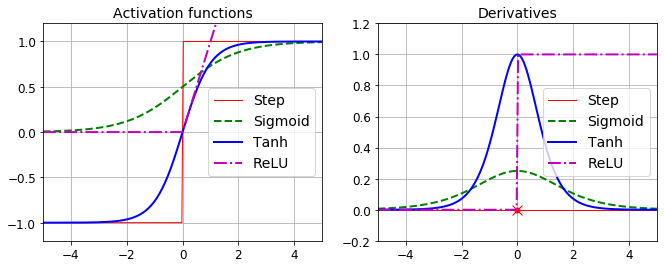

In [68]:
z = np.linspace(-5, 5, 200)
plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), 'r-', lw=1, label='Step')
plt.plot(z, sigmoid(z), 'g--', lw=2, label='Sigmoid')
plt.plot(z, np.tanh(z), 'b-', lw=2, label='Tanh')
plt.plot(z, relu(z), 'm-.', lw=2, label='ReLU')
plt.grid(True) # 添加网格
plt.legend(loc='center right', fontsize=14)
plt.title('Activation functions', fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), 'r-', lw=1, label='Step') # 阶跃函数各点导数
plt.plot(0, 0, 'ro', ms=5) # 点加叉着重号的画法
plt.plot(0, 0, 'rx', ms=10)
plt.plot(z, derivative(sigmoid, z), 'g--', lw=2, label='Sigmoid') # sigmoid函数各点导数
plt.plot(z, derivative(np.tanh, z), 'b-', lw=2, label='Tanh') # TanH
plt.plot(z, derivative(relu, z), 'm-.', lw=2, label='ReLU') # 阶跃函数各点导数
plt.grid(True) # 添加网格
plt.legend(loc='center right', fontsize=14)
plt.title('Derivatives', fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

## 3 - MLP 解决 XOR 问题

In [69]:
def heaviside(z):
    return (z >= 0).astype(z.dtype)

def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5) # 计算了两层感知机的前项输出结果 P256

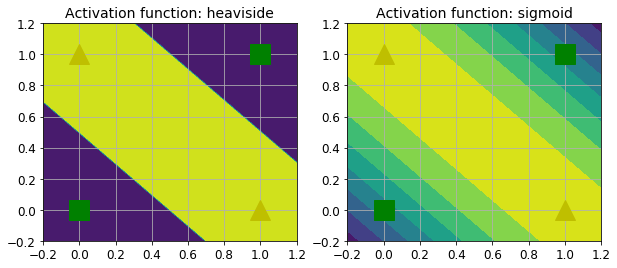

In [73]:
# 这里展示了两层感知机可以解决 XOR 问题。
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], 'gs', ms=20)
plt.plot([0, 1], [1, 0], 'y^', ms=20) # ^ 表示三角形
plt.title('Activation function: heaviside', fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)